In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
import scipy 
import scipy.stats
from scipy import stats
import iminuit
from iminuit import Minuit

mpl.rcParams['font.size'] = 18      # Set the general plotting font size
plt.rc("font", family="serif")
#plt.rc("text", usetex=True)

save_plots = True
verbose = False

In [2]:
data_posi = pd.read_csv("../overvaagningsdata-covid19-28042021-yt76/Municipality_cases_time_series.csv", sep=';', thousands='.', index_col=0)
data_test = pd.read_csv("../overvaagningsdata-covid19-28042021-yt76/Municipality_tested_persons_time_series.csv", sep=';', thousands='.', index_col=0)

# Print how much data is included:
date_start = "2020-08-01"            # This is thus day 0
date_end = "2020-12-25"
print("  Data used: ", date_start, "-", date_end)    

# Number of Positives (P) and Tests (T) for all of Denmark ("all")
P_all = data_posi.loc[date_start:date_end].sum(axis=1)
eP_all = np.sqrt(P_all)
T_all = data_test.loc[date_start:date_end].sum(axis=1)
eT_all = np.sqrt(T_all)

  Data used:  2020-08-01 - 2020-12-25


In [3]:
# Average time between generations (in days):
tG = 4.7

# Number of positive tests and uncertainty, assuming fixed number of daily tests and power law correction:
Power = -0.50

# Correct for effects of weekdays, corrects from 2nd January forward:
frac = [-0.00615632,0.05407795,0.04774371,0.00812457, 0.00122933, -0.01823577,-0.0527193 ]    # Based on 1st of August to 24th of December
frac_fra_lørdag = np.roll(frac, -5)    # This corresponds to 1st of January being a Friday (=4)

# To account for larger uncertainties in positives in data than simply the statistical:
SystError = 0.0                      # Should be included at some point
SystErrorScale = 1.0                 # 1.0 (i.e. doubling of error) works OK!

In [4]:
# These are also the days where corrections are applied:
Plot_StartDay = 0         # 1st of August 2020
Plot_EndDay   = len(P_all)

# Calculate the Scaled Positives (SP):
nAveDailyTests_all = T_all.mean()
fPos_all = P_all / T_all
efPos_all = np.sqrt(fPos_all*(1.0-fPos_all)/T_all + SystError**2)
eP_all  = np.sqrt(T_all*fPos_all*(1-fPos_all)) * (1.0 + SystErrorScale)
SP_all  = P_all  * (T_all / nAveDailyTests_all)**Power
eSP_all = eP_all * (T_all / nAveDailyTests_all)**Power

# Calculate the Scaled CORRECTED Positives (SCP), i.e. apply correction for weekdays:
SCP_all = np.zeros_like(SP_all)
eSCP_all = np.zeros_like(eSP_all)
for i,x,dx in zip(np.arange(Plot_StartDay,Plot_StartDay+len(SP_all[Plot_StartDay:Plot_EndDay])),
                  SP_all[Plot_StartDay:Plot_EndDay], eSP_all[Plot_StartDay:Plot_EndDay]) :
    factor = 1.0               # Just for testing, if the "strength" of the effect is reasonable
    SCP_all[i] = x*(1 - factor * frac_fra_lørdag[i%7])
    eSCP_all[i] = dx*(1 - factor * frac_fra_lørdag[i%7])

# Print the data used for fits:
if verbose:
    print("Average number of PCR tests: ", nAveDailyTests_all)
    print(" Date      Ntest      Nposi (P)    SP         SCP")
    for i in range(len(T_all)) :
        # date_of_month = td.
        print(f"{i+1:4d}   {T_all[i]:10d}  {P_all[i]:8d}    {SP_all[i]:8.0f}   {SCP_all[i]:8.0f}")

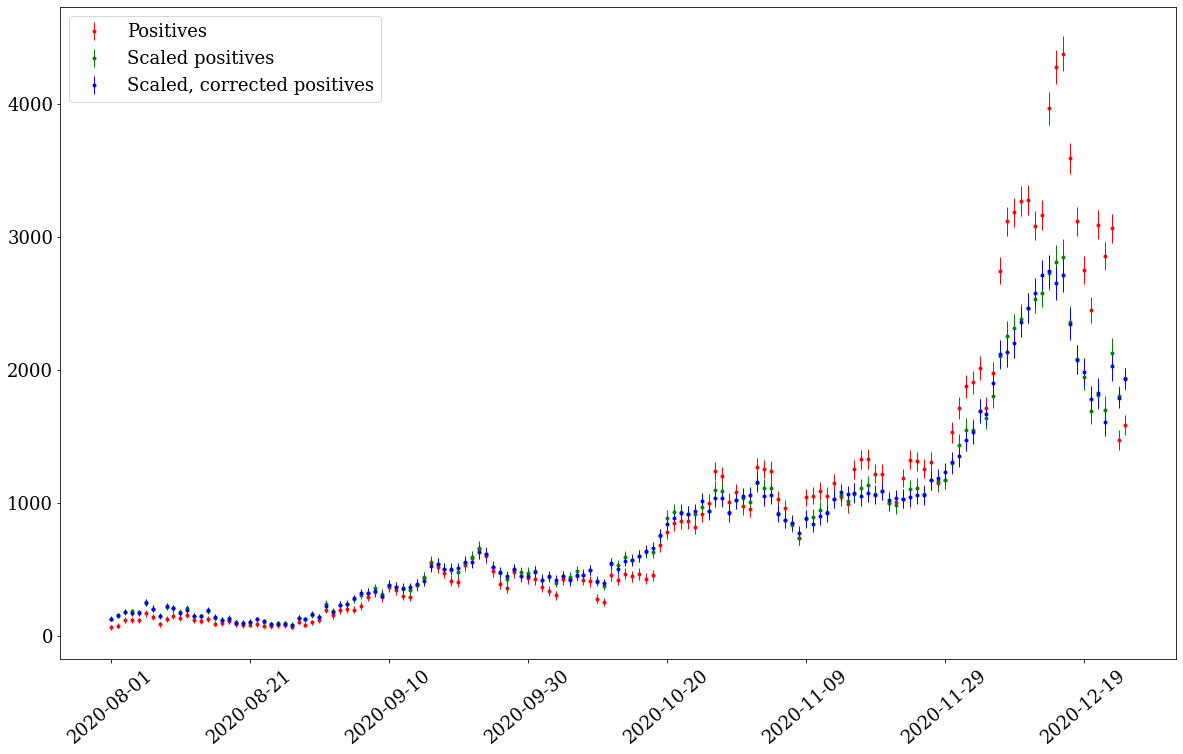

In [5]:
days = np.arange(Plot_EndDay)

fig, ax = plt.subplots(figsize=(20,12))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
for label in ax.get_xticklabels():
        label.set_rotation(40)
ax.errorbar(P_all.index, P_all,yerr=eP_all,fmt='.', linewidth=1, label='Positives', color='red')
ax.errorbar(P_all.index, SP_all,yerr=eP_all,fmt='.', linewidth=1, label='Scaled positives', color='green')
ax.errorbar(P_all.index, SCP_all,yerr=eP_all,fmt='.', linewidth=1, label='Scaled, corrected positives', color='blue')
ax.legend(loc='best')
plt.show()

In [18]:
# "Analytic" R
#Errors are errors on a fraction
#Using first and last point in the data
R_simple = (SCP_all[-1] / SCP_all[0]) ** (tG / Plot_EndDay)
R_sim_err = (SCP_all[-1] / SCP_all[0] * np.sqrt((eSCP_all[-1] / SCP_all[-1]) ** 2 + (eSCP_all[0] / SCP_all[0]) ** 2)) ** (tG / Plot_EndDay)

#Using the spike at mid-december (the highest point on the curve)
R_max = (np.max(SCP_all) / SCP_all[0]) ** (tG / np.argmax(SCP_all))
R_max_err = (np.max(SCP_all) / SCP_all[0] * np.sqrt(eSCP_all[np.argmax(SCP_all)] / np.max(SCP_all)) ** 2 + (eSCP_all[0] / SCP_all[0]) ** 2) ** (tG / np.argmax(SCP_all))

print(f"Using first and last: R= {R_simple:.4f} +/- {R_sim_err:.4f}")
print(f"Using largest spile: R= {R_max:.4f} +/- {R_max_err:.4f}")

print((np.sqrt((eSCP_all[-1] / SCP_all[-1]) ** 2 + (eSCP_all[0] / SCP_all[0]) ** 2) * SCP_all[-1] / SCP_all[0]) **(tG / Plot_EndDay))

Using first and last: R= 1.0900 +/- 1.0433
Using largest spile: R= 1.1118 +/- 0.9885
1.0432589725578638


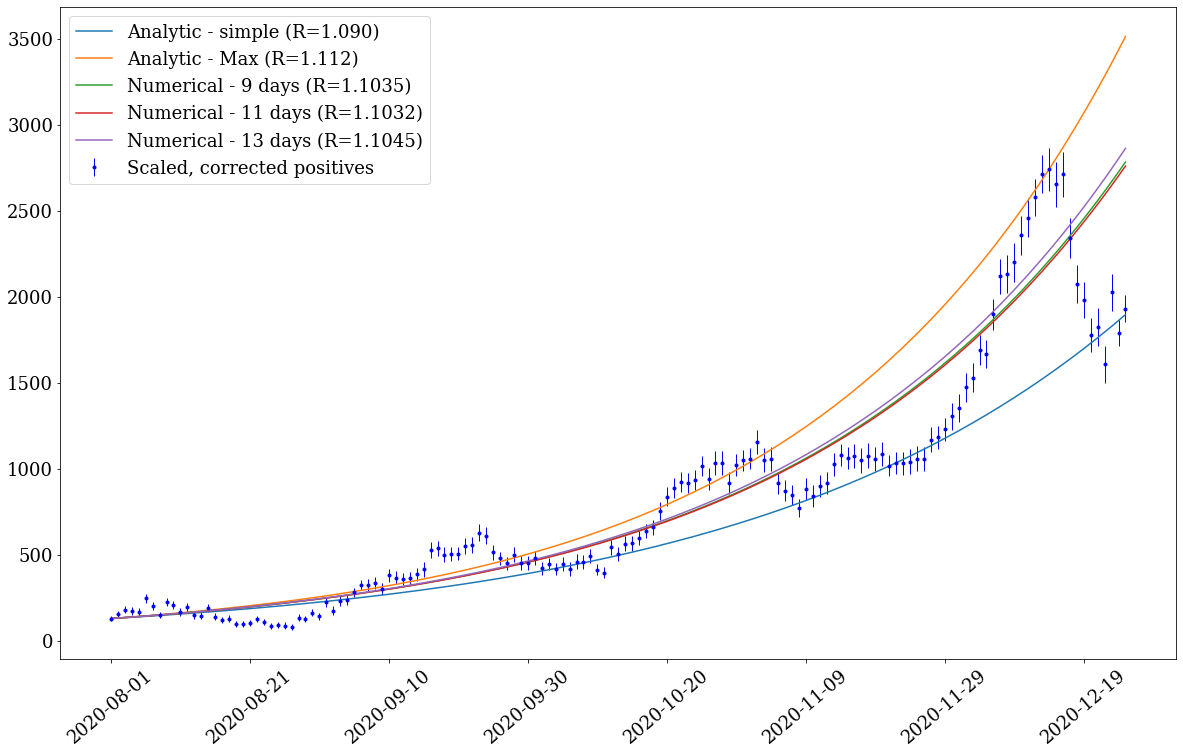

In [7]:
def model(t, R):
    return SCP_all[0] * R ** (t / tG)

fig, ax = plt.subplots(figsize=(20,12))
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
for label in ax.get_xticklabels():
        label.set_rotation(40)
ax.errorbar(P_all.index, SCP_all,yerr=eP_all,fmt='.', linewidth=1, label='Scaled, corrected positives', color='blue')
ax.plot(days, model(days,R_simple),label="Analytic - simple (R=1.090)")
ax.plot(days, model(days,R_max),label="Analytic - Max (R=1.112)")
ax.plot(days, model(days,1.1035),label="Numerical - 9 days (R=1.1035)")
ax.plot(days, model(days,1.1032),label="Numerical - 11 days (R=1.1032)")
ax.plot(days, model(days,1.1045),label="Numerical - 13 days (R=1.1045)")
ax.legend(loc='best')
plt.show()

Day 133 for PCR is not valid!
Prob(Chi2= 42.1, Ndof= 9) = 0.000
Rt fit = 1.100 +- 0.016
S0 fit = 2435.120 +- 24.763 with start value 2579.020


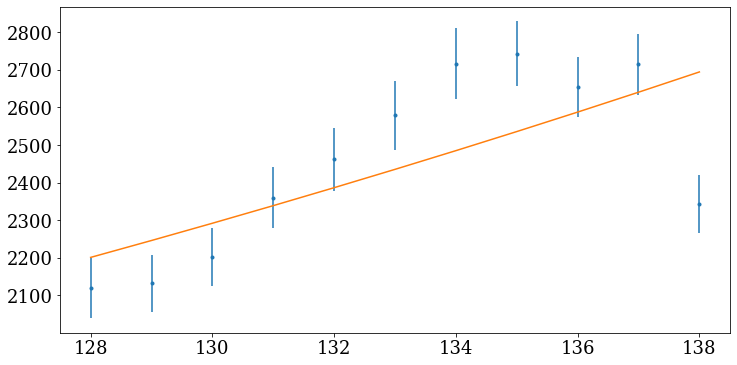

Day 134 for PCR is not valid!
Prob(Chi2= 91.4, Ndof= 9) = 0.000
Rt fit = 1.028 +- 0.014
S0 fit = 2424.818 +- 24.502 with start value 2715.916


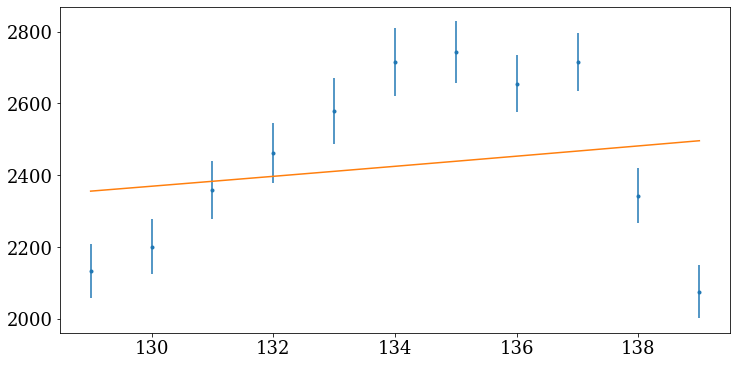

Day 135 for PCR is not valid!
Prob(Chi2=105.7, Ndof= 9) = 0.000
Rt fit = 0.959 +- 0.013
S0 fit = 2413.583 +- 24.495 with start value 2742.658


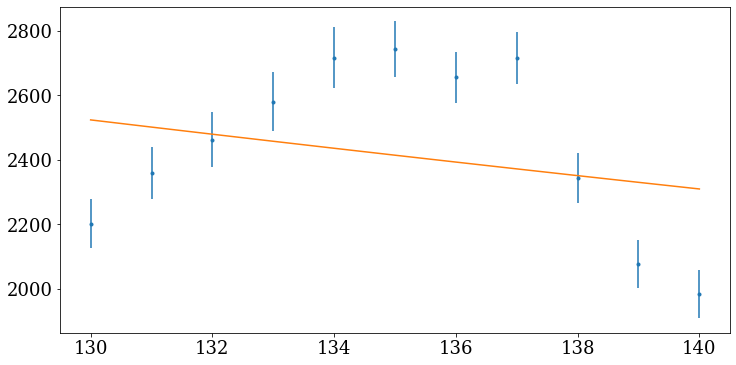

Day 136 for PCR is not valid!
Prob(Chi2=103.8, Ndof= 9) = 0.000
Rt fit = 0.882 +- 0.013
S0 fit = 2375.636 +- 24.374 with start value 2654.737


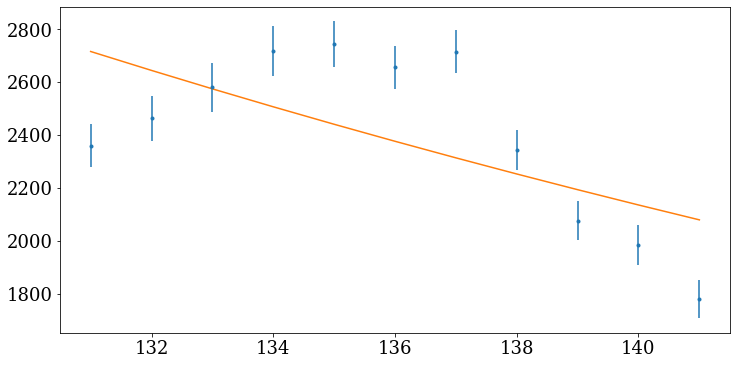

Day 137 for PCR is not valid!
Prob(Chi2= 75.9, Ndof= 9) = 0.000
Rt fit = 0.830 +- 0.012
S0 fit = 2325.837 +- 23.920 with start value 2714.330


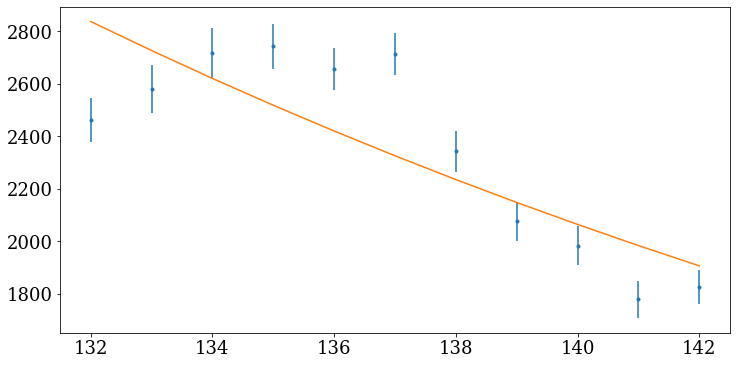

Day 138 for PCR is not valid!
Prob(Chi2= 48.4, Ndof= 9) = 0.000
Rt fit = 0.774 +- 0.012
S0 fit = 2240.964 +- 23.213 with start value 2342.780


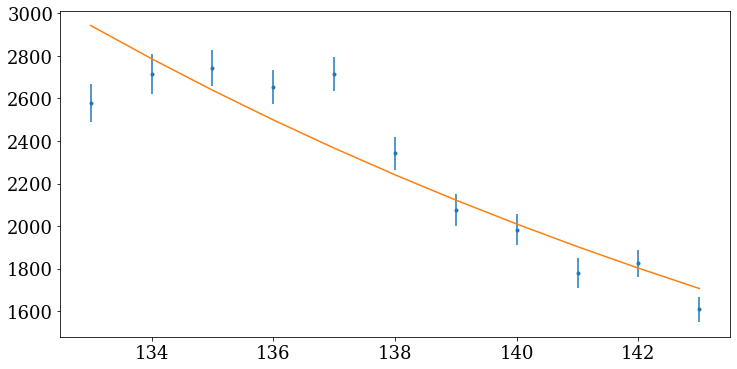

Day 139 for PCR is not valid!
Prob(Chi2= 57.3, Ndof= 9) = 0.000
Rt fit = 0.772 +- 0.012
S0 fit = 2183.116 +- 22.732 with start value 2075.767


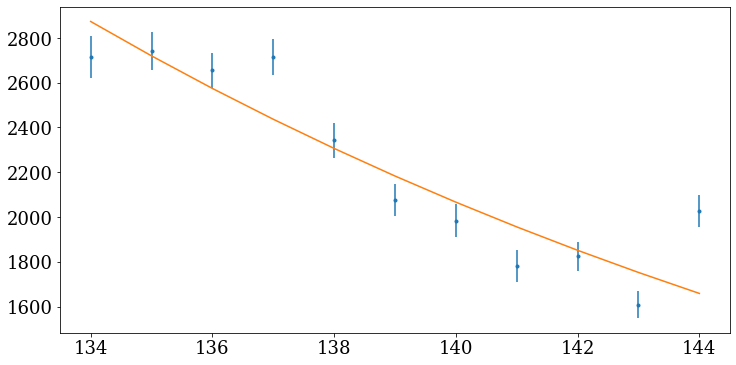

Day 140 for PCR is not valid!
Prob(Chi2= 59.4, Ndof= 9) = 0.000
Rt fit = 0.771 +- 0.013
S0 fit = 2087.473 +- 22.710 with start value 1983.541


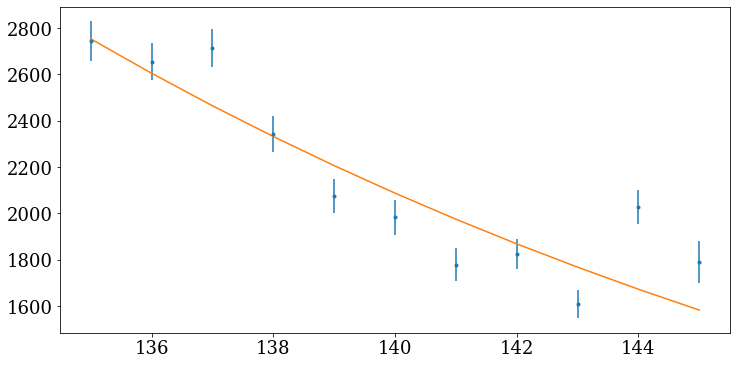

Day 141 for PCR is not valid!
Prob(Chi2= 77.0, Ndof= 9) = 0.000
Rt fit = 0.795 +- 0.015
S0 fit = 2005.469 +- 23.004 with start value 1779.250


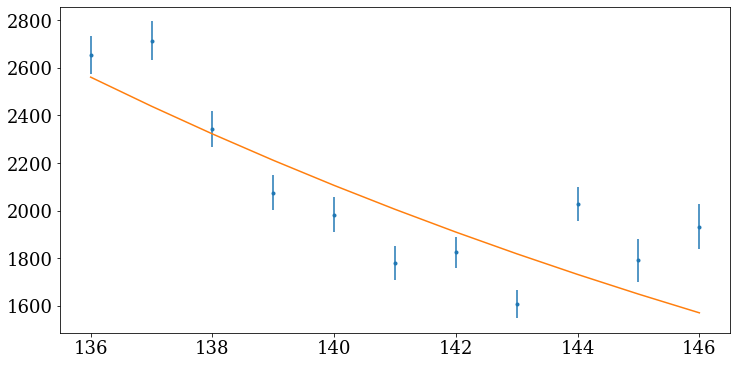

In [8]:
#Interval of days to be fitted for each R
n = 11
k = int((n-1)/2) #Used to get interval

#Weighted average:
#n=13: Rt = 1.0343 +/- 0.0021
#n=11: Rt = 1.0160 +/- 0.0026
#n=9: Rt = 0.99914 +/- 0.0034
#n=7: Rt = 0.9846 +/- 0.0049

#Average:
#n=13: Rt = 1.1045
#n=11: Rt = 1.1032
#n=9: Rt = 1.1035
#N=7: Rt =  1.1070

RPCR_t, RPCR_t_err = [], [] #R and errors on R

for i in range(k, Plot_EndDay-k):
    xfit = days[i-k:i+k+1]
    yfit = SCP_all[i-k:i+k+1]
    y_err = eSCP_all[i-k:i+k+1]
    # Exponential function with base Rt:
    def func_Expo(x, S0, Rt, t0, tG) :
    # NOTE: tG = time_generation, i.e. average time between generations.
        return S0 * Rt**((x-t0)/tG)

    # ChiSquare fit model:
    def chi2_calc0(S0, Rt, t0, tG) :
        y_fit = func_Expo(xfit, S0, Rt, t0, tG)
        chi2 = np.sum(((yfit - y_fit) / y_err)**2)
        return chi2

    minuit0 = Minuit(chi2_calc0, S0=SCP_all[i], Rt=1.0, t0=i, fix_t0=True, tG=4.7, fix_tG=True, print_level=0, errordef=1.0)
    minuit0.migrad();                                                  
    
    
    # Here we extract the fitting parameters and their errors
    S0_fit = minuit0.values['S0'];       sigma_S0_fit = minuit0.errors['S0']
    Rt_fit = minuit0.values['Rt'];       sigma_Rt_fit = minuit0.errors['Rt']
    t0_fit = minuit0.values['t0'];       sigma_t0_fit = minuit0.errors['t0']
    tG_fit = minuit0.values['tG'];       sigma_tG_fit = minuit0.errors['tG']
    
    RPCR_t.append(Rt_fit)
    RPCR_t_err.append(sigma_Rt_fit)
    
    # Calcuate fit quality:
    Chi2_fit = minuit0.fval       # The Chi2 value
    Npoints = len(xfit) # Number of points fitted
    Nvar = 2                      # Number of variables (tG is fixed!)
    Ndof_fit = Npoints - Nvar     # Number of degrees of freedom = Number of data points - Number of variables
    Prob_fit = stats.chi2.sf(Chi2_fit, Ndof_fit)    # The chi2 probability given N degrees of freedom
    #p_fac.append(-np.log10(Prob_fit / (1-Prob_fit)))
    #For testing
    #print(f"  Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")
    #print(f"  Rt fit = {minuit0.values['Rt']:5.3f} +- {minuit0.errors['Rt']:5.3f}")
    if not minuit0.valid or Prob_fit < 0.0001:
        print(f"Day {i:d} for PCR is not valid!")
        print(f"Prob(Chi2={Chi2_fit:5.1f}, Ndof={Ndof_fit:2d}) = {Prob_fit:5.3f}")
        print(f"Rt fit = {minuit0.values['Rt']:5.3f} +- {minuit0.errors['Rt']:5.3f}")
        print(f"S0 fit = {minuit0.values['S0']:5.3f} +- {minuit0.errors['S0']:5.3f} with start value {SCP_all[i]:5.3f}")
        fig, ax = plt.subplots(figsize=(12,6))
        ax.errorbar(xfit,yfit,yerr=y_err,fmt='.')
        ax.plot(xfit,func_Expo(xfit,S0_fit,Rt_fit,t0_fit,tG_fit))
        plt.show()

In [9]:
def ChiSquareMean(val, err): #From AppStat
    f_app = np.sum(val / err ** 2) / np.sum(1 / err ** 2)
    f_err = 1 / np.sqrt(np.sum(1 / err ** 2))
    Chi2 = np.sum((val - f_app) ** 2 / err ** 2)
    p = stats.chi2.sf(Chi2, val.size - 1)
    return f_app, f_err, Chi2, p

Rt, Rt_err = np.array(RPCR_t), np.array(RPCR_t_err)

print(Rt.mean())

print(ChiSquareMean(Rt,Rt_err))

1.1031913561171902
(1.0159650920293624, 0.0025856008309266833, 4937.880427321472, 0.0)
